# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name(s):Suhail Bashir

Student number(s):2307236

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>

</div>

In [1]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Enter data folder location
loc = "./MEx"

/Users/suhailbashir/miniconda3/envs/kaggle/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)
    
    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df
    
    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...
1,03,04,2,act,acc,time acc_0 acc_1 acc_2 0 ...
2,03,06,1,act,acc,time acc_0 acc_1 acc_2 0 ...
3,03,04,1,act,acc,time acc_0 acc_1 acc_2 0 ...
4,03,03,1,act,acc,time acc_0 acc_1 acc_2 0 ...


Dataframe with one measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


In [3]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""

# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.
    
for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())
    
    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue
        
        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()
        
        records_windowed.append(tmp_data)
        
df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,03,02,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,03,02,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,03,02,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,03,02,1,act,acc,time acc_0 acc_1 acc_2 80...,4


Dataframe with one windowed measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


<a id='task1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>

</div>

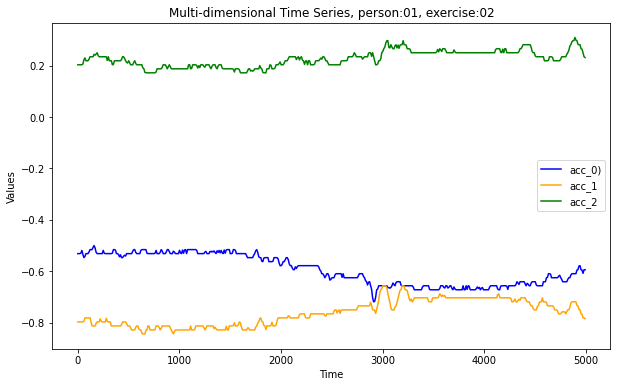

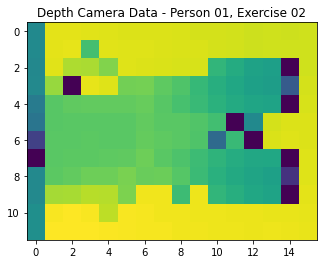

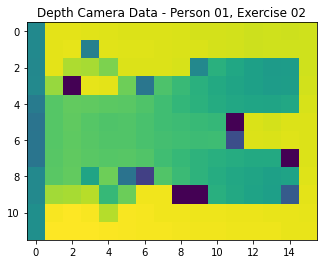

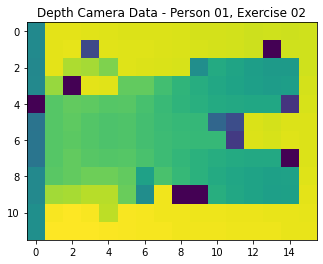

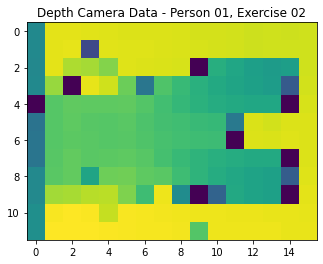

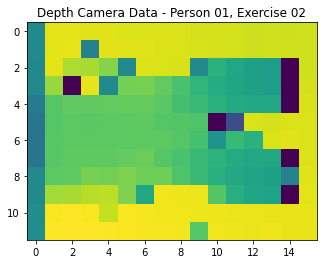

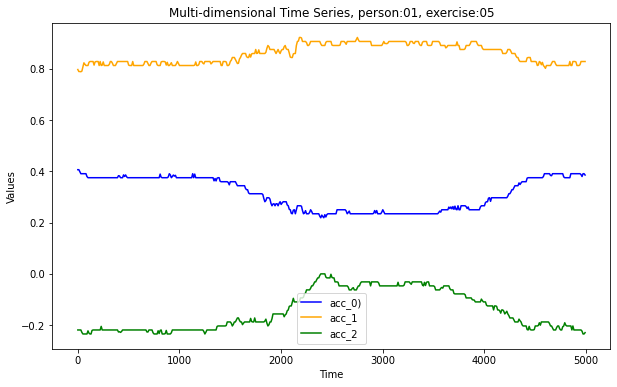

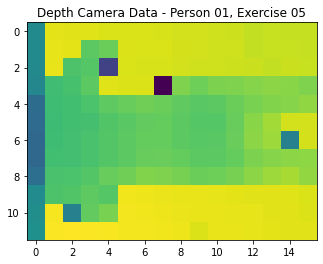

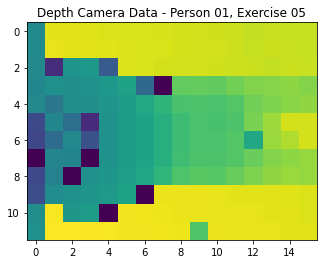

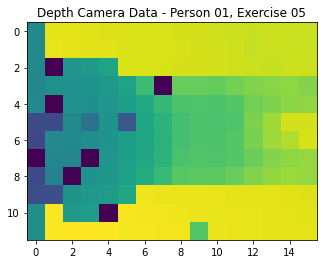

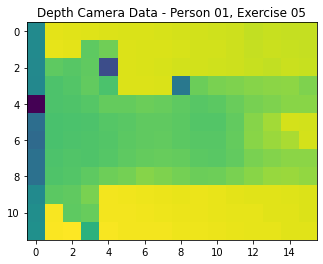

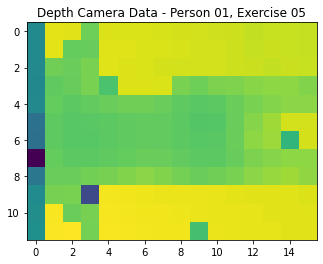

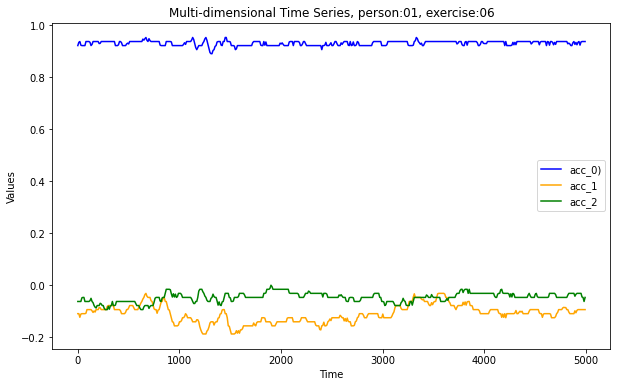

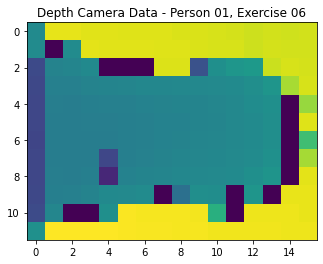

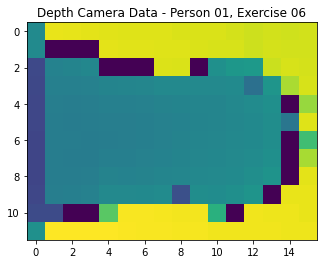

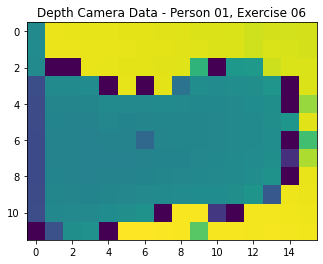

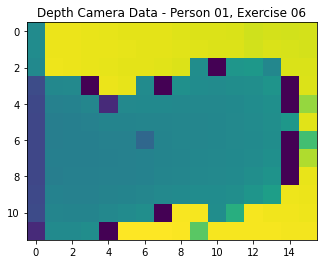

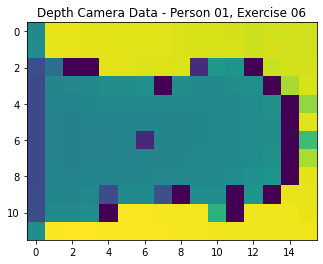

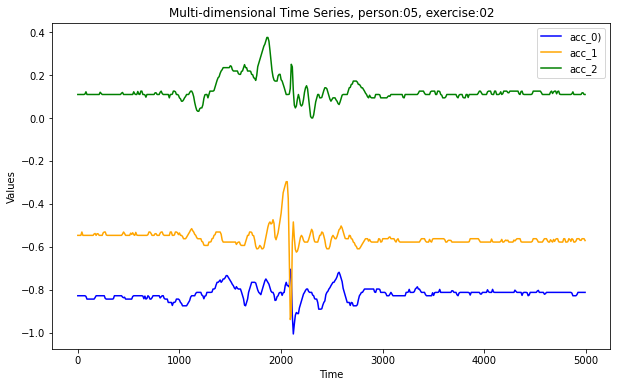

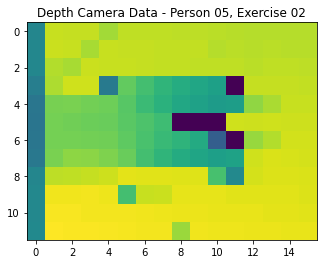

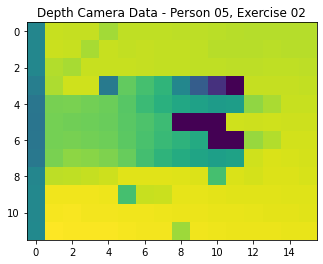

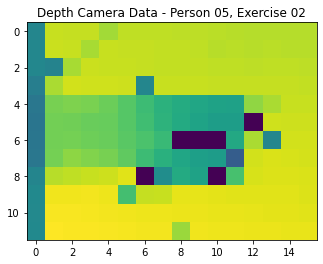

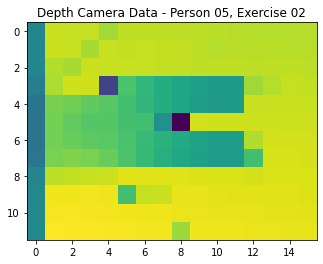

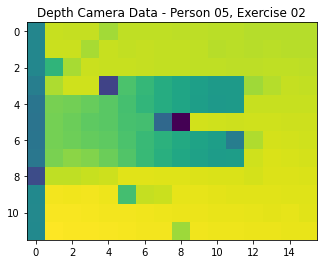

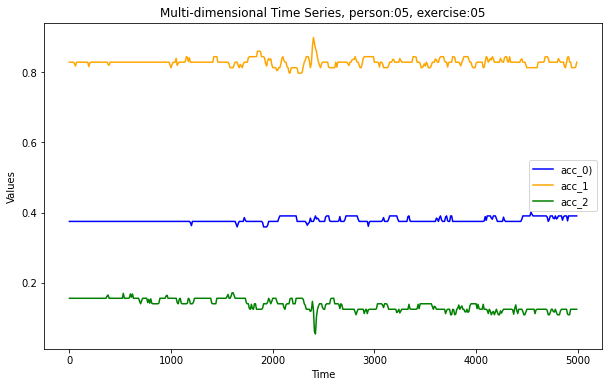

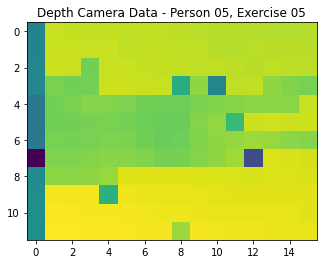

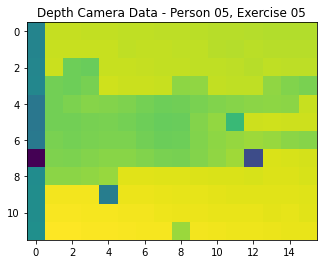

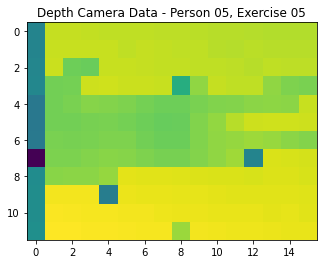

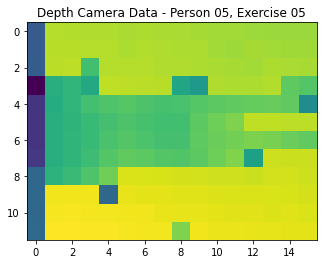

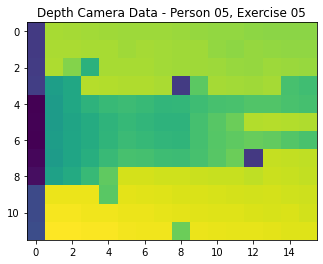

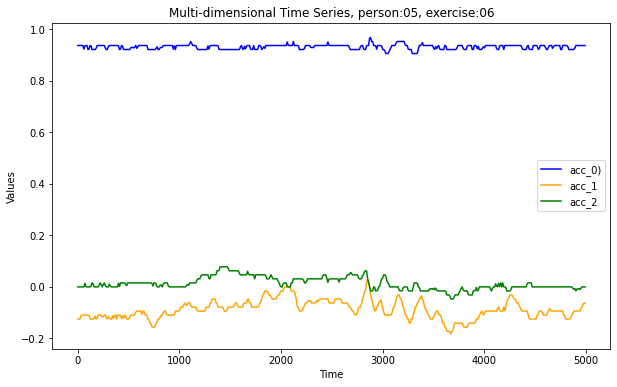

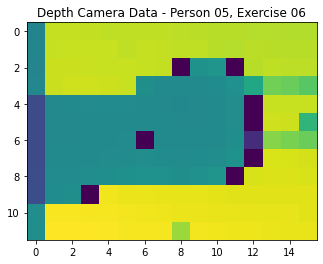

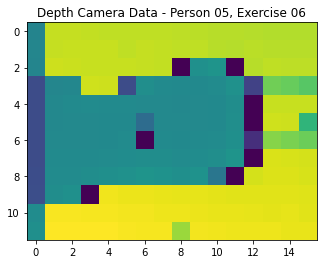

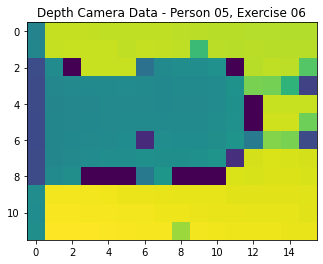

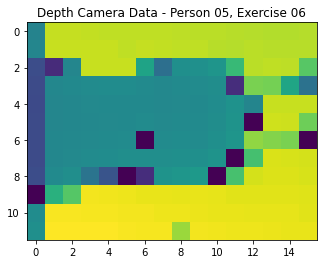

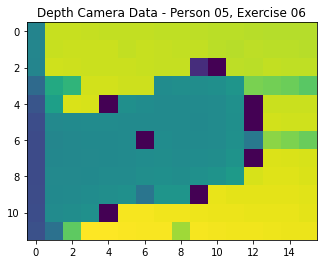

In [4]:
# 1.1. Visualize selected samples for both modalities

### Your code begins here ###
subject_ids = ["01", "05"]
exercise_ids = ["02", "05", "06"]

def plot_acceler(df, sub_id, exercise_id):
    '''plots accelerometer data'''
    
    first_comp = df['acc_0']
    second_comp = df['acc_1']
    third_comp = df['acc_2']
    time = df['time']

    plt.figure(figsize=(10, 6))

    plt.plot(time, first_comp, label='acc_0)', color='blue')
    plt.plot(time, second_comp, label='acc_1', color='orange')
    plt.plot(time, third_comp, label='acc_2', color='green')

    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title(f"Multi-dimensional Time Series, person:{sub_id}, exercise:{exercise_id}")
    plt.legend()
    plt.show()

def plot_depth(df, sub_id, exercise_id):
    '''plots depth camera data'''
    for index, row in df.iterrows():
        plt.figure()
        time = row.values[0]
        depth_image = row.values[1:]
        
        plt.imshow(depth_image.reshape(12,16))
        plt.title(f"Depth Camera Data - Person {sub_id}, Exercise {exercise_id}")
        plt.show()
        

for sub_id in subject_ids:
    for exercise_id in exercise_ids:
        filtered_df = df_records_windowed[(df_records_windowed['subject_id'] == sub_id) & (df_records_windowed['exercise_id'] == exercise_id)]
        acc_df = filtered_df[filtered_df['sensor'] == 'acc'].iloc[0]['df']
        depth_df = filtered_df[filtered_df['sensor'] == 'dc'].iloc[0]['df']
        
        plot_acceler(acc_df, sub_id, exercise_id)
        plot_depth(depth_df, sub_id, exercise_id)
        
### Your code ends here ###

<a id='task1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
  
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [5]:
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

### Your code begins here ###
training_ids = ['01', '02', '03', '04', '05', '06', '07']
test_ids = ['08', '09', '10']

df_train_dc = df_records_windowed[(df_records_windowed['subject_id'].isin(training_ids)) & (df_records_windowed['sensor'] == 'dc')].copy()
df_train_acc = df_records_windowed[(df_records_windowed['subject_id'].isin(training_ids)) & (df_records_windowed['sensor'] == 'acc')].copy()

df_test_dc = df_records_windowed[(df_records_windowed['subject_id'].isin(test_ids)) & (df_records_windowed['sensor'] == 'dc')].copy()
df_test_acc = df_records_windowed[(df_records_windowed['subject_id'].isin(test_ids)) & (df_records_windowed['sensor'] == 'acc')].copy()

for index, row in df_train_acc.iterrows():
    if len(df_train_dc[(df_train_dc['subject_id'] == row['subject_id']) & (df_train_dc['exercise_id'] == row['exercise_id']) & ((df_train_dc['window_idx'] == row['window_idx']))]) < 1:
        df_train_acc.drop(index,inplace=True)

print(f"Number of windows in training dc data: {len(df_train_dc)}")
print(f"Number of windows in training acc data: {len(df_train_acc)}")

print(f"Number of windows in testing acc data: {len(df_test_acc)}")
print(f"Number of windows in testing dc data: {len(df_train_dc)}")

def print_stats(df, name):
    '''statistics of each example'''
    for i in range(len(df)):
        print(f"Dimension of window {i} of data {name}: {df.iloc[0]['df'].shape}")

print_stats(df_train_acc,"train_acc")
print_stats(df_train_dc, "train_dc")
print_stats(df_test_acc, "test_acc")
print_stats(df_test_dc, "test_dc")
### Your code ends here ###

Number of windows in training dc data: 1486
Number of windows in training acc data: 1486
Number of windows in testing acc data: 598
Number of windows in testing dc data: 1486
Dimension of window 0 of data train_acc: (500, 4)
Dimension of window 1 of data train_acc: (500, 4)
Dimension of window 2 of data train_acc: (500, 4)
Dimension of window 3 of data train_acc: (500, 4)
Dimension of window 4 of data train_acc: (500, 4)
Dimension of window 5 of data train_acc: (500, 4)
Dimension of window 6 of data train_acc: (500, 4)
Dimension of window 7 of data train_acc: (500, 4)
Dimension of window 8 of data train_acc: (500, 4)
Dimension of window 9 of data train_acc: (500, 4)
Dimension of window 10 of data train_acc: (500, 4)
Dimension of window 11 of data train_acc: (500, 4)
Dimension of window 12 of data train_acc: (500, 4)
Dimension of window 13 of data train_acc: (500, 4)
Dimension of window 14 of data train_acc: (500, 4)
Dimension of window 15 of data train_acc: (500, 4)
Dimension of window

Dimension of window 1097 of data train_acc: (500, 4)
Dimension of window 1098 of data train_acc: (500, 4)
Dimension of window 1099 of data train_acc: (500, 4)
Dimension of window 1100 of data train_acc: (500, 4)
Dimension of window 1101 of data train_acc: (500, 4)
Dimension of window 1102 of data train_acc: (500, 4)
Dimension of window 1103 of data train_acc: (500, 4)
Dimension of window 1104 of data train_acc: (500, 4)
Dimension of window 1105 of data train_acc: (500, 4)
Dimension of window 1106 of data train_acc: (500, 4)
Dimension of window 1107 of data train_acc: (500, 4)
Dimension of window 1108 of data train_acc: (500, 4)
Dimension of window 1109 of data train_acc: (500, 4)
Dimension of window 1110 of data train_acc: (500, 4)
Dimension of window 1111 of data train_acc: (500, 4)
Dimension of window 1112 of data train_acc: (500, 4)
Dimension of window 1113 of data train_acc: (500, 4)
Dimension of window 1114 of data train_acc: (500, 4)
Dimension of window 1115 of data train_acc: (5

Dimension of window 352 of data train_dc: (5, 193)
Dimension of window 353 of data train_dc: (5, 193)
Dimension of window 354 of data train_dc: (5, 193)
Dimension of window 355 of data train_dc: (5, 193)
Dimension of window 356 of data train_dc: (5, 193)
Dimension of window 357 of data train_dc: (5, 193)
Dimension of window 358 of data train_dc: (5, 193)
Dimension of window 359 of data train_dc: (5, 193)
Dimension of window 360 of data train_dc: (5, 193)
Dimension of window 361 of data train_dc: (5, 193)
Dimension of window 362 of data train_dc: (5, 193)
Dimension of window 363 of data train_dc: (5, 193)
Dimension of window 364 of data train_dc: (5, 193)
Dimension of window 365 of data train_dc: (5, 193)
Dimension of window 366 of data train_dc: (5, 193)
Dimension of window 367 of data train_dc: (5, 193)
Dimension of window 368 of data train_dc: (5, 193)
Dimension of window 369 of data train_dc: (5, 193)
Dimension of window 370 of data train_dc: (5, 193)
Dimension of window 371 of data

Dimension of window 1202 of data train_dc: (5, 193)
Dimension of window 1203 of data train_dc: (5, 193)
Dimension of window 1204 of data train_dc: (5, 193)
Dimension of window 1205 of data train_dc: (5, 193)
Dimension of window 1206 of data train_dc: (5, 193)
Dimension of window 1207 of data train_dc: (5, 193)
Dimension of window 1208 of data train_dc: (5, 193)
Dimension of window 1209 of data train_dc: (5, 193)
Dimension of window 1210 of data train_dc: (5, 193)
Dimension of window 1211 of data train_dc: (5, 193)
Dimension of window 1212 of data train_dc: (5, 193)
Dimension of window 1213 of data train_dc: (5, 193)
Dimension of window 1214 of data train_dc: (5, 193)
Dimension of window 1215 of data train_dc: (5, 193)
Dimension of window 1216 of data train_dc: (5, 193)
Dimension of window 1217 of data train_dc: (5, 193)
Dimension of window 1218 of data train_dc: (5, 193)
Dimension of window 1219 of data train_dc: (5, 193)
Dimension of window 1220 of data train_dc: (5, 193)
Dimension of

Dimension of window 365 of data test_acc: (500, 4)
Dimension of window 366 of data test_acc: (500, 4)
Dimension of window 367 of data test_acc: (500, 4)
Dimension of window 368 of data test_acc: (500, 4)
Dimension of window 369 of data test_acc: (500, 4)
Dimension of window 370 of data test_acc: (500, 4)
Dimension of window 371 of data test_acc: (500, 4)
Dimension of window 372 of data test_acc: (500, 4)
Dimension of window 373 of data test_acc: (500, 4)
Dimension of window 374 of data test_acc: (500, 4)
Dimension of window 375 of data test_acc: (500, 4)
Dimension of window 376 of data test_acc: (500, 4)
Dimension of window 377 of data test_acc: (500, 4)
Dimension of window 378 of data test_acc: (500, 4)
Dimension of window 379 of data test_acc: (500, 4)
Dimension of window 380 of data test_acc: (500, 4)
Dimension of window 381 of data test_acc: (500, 4)
Dimension of window 382 of data test_acc: (500, 4)
Dimension of window 383 of data test_acc: (500, 4)
Dimension of window 384 of data

Example from training accelerometer data


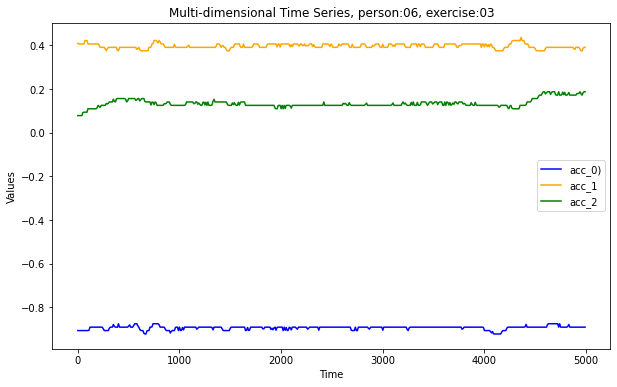

Example from testing accelerometer data


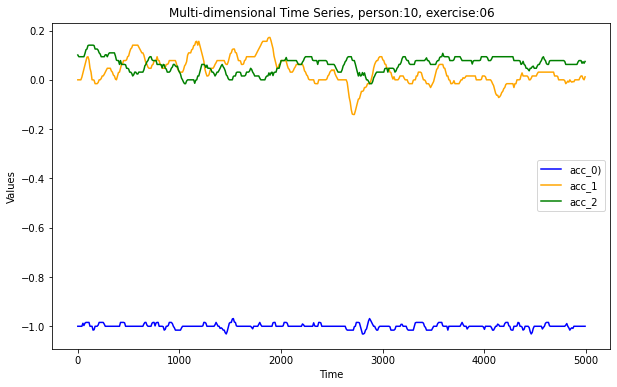

Example from training depth camera data


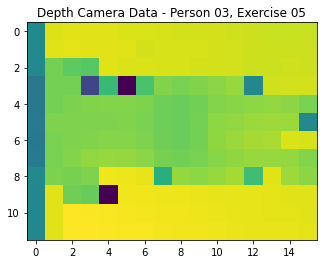

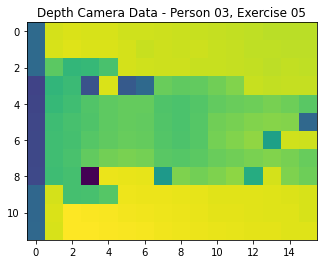

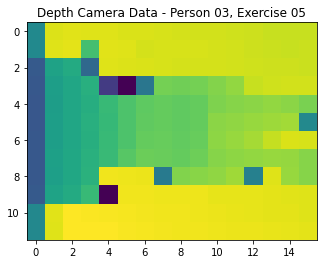

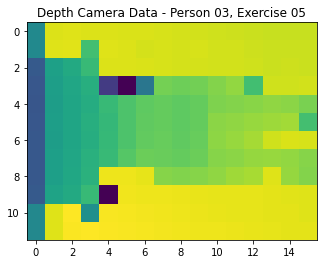

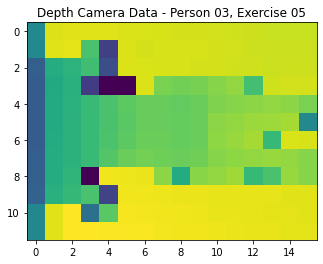

Example from testing depth camera data


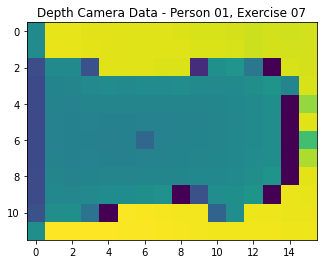

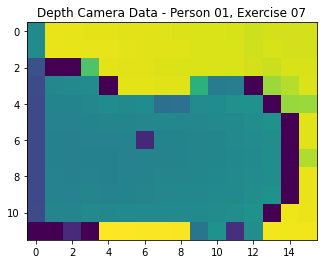

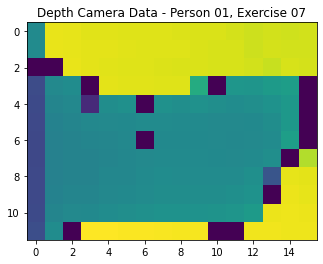

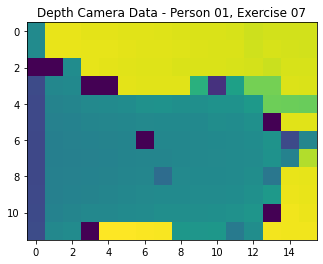

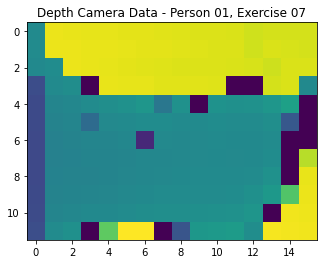

In [6]:
def plot_examples(train_df_ac, test_df_ac, train_df_dc, test_df_dc):
    '''some random examples from training and testing data'''
    
    print("Example from training accelerometer data")
    subject = np.random.choice(train_df_ac['subject_id'])
    exercise = np.random.choice(train_df_ac['exercise_id'])
    df = train_df_ac[(train_df_ac['exercise_id'] == exercise) & (train_df_ac['subject_id'] == subject)].iloc[0]['df']
    plot_acceler(df, subject, exercise)
    
    print("Example from testing accelerometer data")
    subject = np.random.choice(test_df_ac['subject_id'])
    exercise = np.random.choice(test_df_ac['exercise_id'])
    df = test_df_ac[(test_df_ac['exercise_id'] == exercise) & (test_df_ac['subject_id'] == subject)].iloc[0]['df']
    plot_acceler(df, subject, exercise)
    
    print("Example from training depth camera data")
    subject = np.random.choice(train_df_dc['subject_id'])
    exercise = np.random.choice(train_df_dc['exercise_id'])
    df = train_df_dc[(train_df_dc['exercise_id'] == exercise) & (train_df_dc['subject_id'] == subject)].iloc[0]['df']
    plot_depth(df, subject, exercise)
    
    print("Example from testing depth camera data")
    subject = np.random.choice(test_df_dc['subject_id'])
    exercise = np.random.choice(test_df_dc['exercise_id'])
    df = test_df_dc[(test_df_dc['exercise_id'] == exercise) & (test_df_dc['subject_id'] == subject)].iloc[0]['df']
    plot_depth(df, subject, exercise)
    

plot_examples(df_train_acc, df_test_acc, df_train_dc, df_train_dc)

# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as 
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

In [7]:
from scipy import signal
from sklearn.preprocessing import StandardScaler

def process_group(group, modality="Acc"):
    '''processes each group with same subject and exercise_id'''
    data = []
    if modality == "Acc":
        for index, row in group.iterrows():
            acc_data = row['df'][['acc_0', 'acc_1', 'acc_2']].to_numpy()
            data.append(signal.resample(acc_data, 125).T)
        data = np.concatenate(data, axis=0)
        return data.reshape(-1,3,data.shape[-1])
    else:
        for index, row in group.iterrows():
            dc_data = row['df'].iloc[:,1:]
            data.append(dc_data)
        data = np.concatenate(data, axis=0)
        window_data = data.reshape(-1,5,data.shape[-1])
    
    return window_data

def combine_window_df(df,modality='Acc'):
    results = []
    for (subject_id, exercise_id), group in df.groupby(['subject_id', 'exercise_id']):
        array_data = process_group(group, modality)
        results.append({
            'subject_id': subject_id,
            'exercise_id': exercise_id,
            'data_array': array_data
        })
    final_df = pd.DataFrame(results)
    return final_df

def standardize_data(train_df, test_df):
    '''standardize training and testing data'''
    _train_data = []
    for i in range(len(train_df)):
        _train_data.append(train_df.iloc[i]['data_array'])
    
    _test_data = []
    for i in range(len(test_df)):
        _test_data.append(test_df.iloc[i]['data_array'])
    
    train_data = np.concatenate(_train_data, axis=0)
    test_data = np.concatenate(_test_data, axis=0)

    reshape_train_data = train_data.reshape(-1,3)
    reshape_test_data = test_data.reshape(-1,3)
    
    scaler = StandardScaler()
    stand_train_data = scaler.fit_transform(reshape_train_data)
    stand_train_data = stand_train_data.reshape(-1, train_data.shape[1], train_data.shape[2])
    
    stand_test_data = scaler.transform(reshape_test_data)
    stand_test_data = stand_test_data.reshape(-1, test_data.shape[1], test_data.shape[2])
    
    start = 0
    for i, d in enumerate(_train_data):
        end = start + d.shape[0]
        train_df.iloc[i]['data_array'] = stand_train_data[start:end]
        start = end
    
    start = 0
    for i, d in enumerate(_test_data):
        end = start + d.shape[0]
        test_df.iloc[i]['data_array'] = stand_test_data[start:end]
        start = end
    
    return train_df, test_df

In [8]:
df_train_acc_down = combine_window_df(df_train_acc, modality='Acc')
df_test_acc_down = combine_window_df(df_test_acc, modality='Acc')

df_train_dc_down = combine_window_df(df_train_dc, modality="dc")
df_test_dc_down = combine_window_df(df_test_dc, modality="dc")

In [9]:
df_train_acc_st, df_test_acc_st = standardize_data(df_train_acc_down, df_test_acc_down)
df_train_dc_st, df_test_dc_st = standardize_data(df_train_dc_down, df_test_dc_down)

In [10]:
def pca_reduce_dim(df_train, df_test, components=5):
    '''applies pca on training and testing data'''
    
    df_train_ = df_train.copy()
    df_test_ = df_test.copy()
    train_ = []
    test_ = []
    
    for index, rows in df_train.iterrows():
        data = rows['data_array']
        train_.append(data)
    
    for index, rows in df_test.iterrows():
        data = rows['data_array']
        test_.append(data)

    train = np.concatenate(train_, axis=0)
    test = np.concatenate(test_, axis=0)
    
    pca = PCA(n_components=components)

    train_pca = pca.fit_transform(train.reshape(-1, train.shape[-1]))
    test_pca = pca.transform(test.reshape(-1, test.shape[-1]))
    
    train_pca = train_pca.reshape(-1, train.shape[1]*components)
    test_pca = test_pca.reshape(-1, test.shape[1]*components)

    start = 0
    for i, d in enumerate(train_):
        end = start + d.shape[0]
        df_train_.iloc[i]['data_array'] = train_pca[start:end]
        start = end
    
    start = 0
    for i, d in enumerate(test_):
        end = start + d.shape[0]
        df_test_.iloc[i]['data_array'] = test_pca[start:end]
        start = end
    
    return df_train_, df_test_

In [11]:
def lda_reduce_dim(df_train, df_test, components=5):
    '''applies lda on training and testing data'''
    df_train_ = df_train.copy()
    df_test_ = df_test.copy()
    
    data_train_ = []
    data_test_ = []
    
    labels_train = []
    labels_test = []
    
    for index, row in df_train.iterrows():
        exercise_data = row['data_array']
        exercise_id = row['exercise_id']
        data_train_.append(exercise_data)
        labels_train.extend([exercise_id]*exercise_data.shape[0]*exercise_data.shape[1])
    
    for index, row in df_test.iterrows():
        exercise_data = row['data_array']
        exercise_id = row['exercise_id']
        data_test_.append(exercise_data)
        labels_test.extend([exercise_id]*exercise_data.shape[0]*exercise_data.shape[1])
        
    data_train = np.concatenate(data_train_, axis=0)
    data_test = np.concatenate(data_test_, axis=0)
    
    lda = LDA(n_components=components)
    
    train_lda = lda.fit_transform(data_train.reshape(-1, data_train.shape[-1]), np.array(labels_train))
    test_lda = lda.transform(data_test.reshape(-1, data_test.shape[-1]))
    train_lda = train_lda.reshape(-1, data_train.shape[1]*components)
    test_lda = test_lda.reshape(-1, data_test.shape[1]*components)
    
    start = 0
    for i, d in enumerate(data_train_):
        end = start + d.shape[0]
        df_train_.iloc[i]['data_array'] = train_lda[start:end]
        start = end
    
    start = 0
    for i, d in enumerate(data_test_):
        end = start + d.shape[0]
        df_test_.iloc[i]['data_array'] = test_lda[start:end]
        start = end

    
    return df_train_, df_test_

In [12]:
df_train_acc_pca, df_test_acc_pca = pca_reduce_dim(df_train_acc_st, df_test_acc_st)
df_train_acc_lda, df_test_acc_lda = lda_reduce_dim(df_train_acc_st, df_test_acc_st)

df_train_dc_pca, df_test_dc_pca = pca_reduce_dim(df_train_dc_st, df_test_dc_st)
df_train_dc_lda, df_test_dc_lda = lda_reduce_dim(df_train_dc_st, df_test_dc_st)

In [13]:
#training accelerometer data with pca features
df_train_acc_pca.head()

,subject_id,exercise_id,data_array
0,01,01,"[[9.446390014019354, -0.10016079685926285, 1.3..."
1,01,02,"[[12.162540415286935, 1.1422195985026389, 0.15..."
2,01,03,"[[12.773456168091046, 0.4693477395556291, 0.49..."
3,01,04,"[[0.20674200291898506, -0.10944079231858653, 3..."
4,01,05,"[[-6.048560287785612, 0.5694053610907848, 1.09..."


In [14]:
#each rows has n_windows and each window has 15 features (5*3)
df_train_acc_pca.iloc[0]['data_array'].shape

(30, 15)

In [15]:
#training depth camera data with pca features
df_train_acc_pca.head()

,subject_id,exercise_id,data_array
0,01,01,"[[9.446390014019354, -0.10016079685926285, 1.3..."
1,01,02,"[[12.162540415286935, 1.1422195985026389, 0.15..."
2,01,03,"[[12.773456168091046, 0.4693477395556291, 0.49..."
3,01,04,"[[0.20674200291898506, -0.10944079231858653, 3..."
4,01,05,"[[-6.048560287785612, 0.5694053610907848, 1.09..."


In [16]:
#each rows and n_windows and each windows 25 features (5*5)
df_train_dc_pca.iloc[0]['data_array'].shape

(30, 25)

In [17]:
def un_window(df):
    '''makes each window as a separate row in a dataframe'''
    rows = []
    for index, row in df.iterrows():
        subject_id = row['subject_id']
        exercise_id = row['exercise_id']
        data_array = row['data_array']

        for sample in data_array:
            rows.append({
                "subject_id": subject_id,
                "exercise_id": exercise_id,
                **{f"feature_{i}": value for i, value in enumerate(sample.flatten())} 
            })
    return pd.DataFrame(rows)

In [18]:
df_train_acc_pca_un = un_window(df_train_acc_pca)
df_test_acc_pca_un = un_window(df_test_acc_pca)

df_train_dc_pca_un = un_window(df_train_dc_pca)
df_test_dc_pca_un = un_window(df_test_dc_pca)

df_train_acc_lda_un = un_window(df_train_acc_lda)
df_test_acc_lda_un = un_window(df_test_acc_lda)

df_train_dc_lda_un = un_window(df_train_dc_lda)
df_test_dc_lda_un = un_window(df_test_dc_lda)

In [19]:
#un_windowed features (1486 training examples, each example has 15 features)
df_train_acc_pca_un

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14
0,01,01,9.446390,-0.100161,1.337527,-0.427952,1.584236,12.676037,-4.282097,0.137266,-0.039003,0.860734,-4.428180,-10.071520,-1.544047,0.527774,-0.290541
1,01,01,10.279451,0.350062,-0.832784,1.823521,-0.705574,12.103406,2.431883,-2.955709,1.072821,0.080378,-7.641348,4.657154,-5.537625,-0.473559,1.398964
2,01,01,10.180005,-0.166872,-0.476363,-2.050209,-0.805986,14.293137,2.083909,2.304167,-1.285808,-0.902564,-2.534229,5.275346,6.331572,0.829374,-1.140164
3,01,01,9.748982,0.166028,1.216415,0.603697,1.552957,13.263542,-3.819407,1.186917,0.599318,0.511031,-3.948800,-9.204254,0.716698,-0.019989,-1.487629
4,01,01,10.551685,-0.028662,-0.874917,1.393513,-1.164957,12.680849,1.390086,-3.396255,0.803509,-0.665111,-6.930082,3.168623,-6.074279,-0.522035,0.673620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,12.300086,-7.560771,0.035711,-0.519517,0.303762,11.008224,7.781488,1.134970,-0.332079,0.664335,-1.311852,-3.603153,-0.773634,0.232074,0.110516
1482,07,07,6.128600,-1.305088,-2.443488,2.473615,2.126193,17.908237,1.058136,1.109456,-1.459882,-0.914960,-4.342852,-0.292144,-0.673540,0.738306,0.836752
1483,07,07,5.948453,1.542386,-1.398224,-1.973479,1.447783,18.141917,-0.848360,0.852931,1.205858,-0.743437,-4.682058,0.066080,0.010413,-0.018325,0.158330
1484,07,07,12.358662,7.042130,-0.388923,0.351646,-0.355926,11.819667,-7.060390,1.025450,0.158701,0.750377,-1.957782,3.005787,-1.393600,-0.586400,-0.549556


In [20]:
df_test_acc_pca_un

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14
0,08,01,12.492836,0.658924,-0.144612,-0.345418,-2.197639,-11.961367,0.277131,2.827529,-0.419420,-0.233447,3.724395,0.022507,7.528342,-0.858772,0.288145
1,08,01,13.014931,0.470656,0.751311,-0.811650,-1.198665,-11.342292,-0.950830,-1.980713,-0.036490,-0.180891,5.162626,-2.415001,-6.752914,-0.468903,0.239336
2,08,01,13.186730,-0.190409,-0.828289,-1.316217,0.401873,-11.848642,1.259839,1.314891,0.302019,0.240283,4.413760,4.752591,4.434546,1.495515,0.409791
3,08,01,13.551650,1.185973,0.069291,0.111171,1.588247,-11.639266,-1.418707,-0.308876,-0.499388,0.095897,4.993377,-5.589644,-1.413905,-2.111044,-0.098033
4,08,01,13.527126,-1.143232,-0.324420,-0.588443,1.805149,-11.646789,1.405238,-0.051287,1.012276,-0.399923,4.609739,5.007637,-0.822361,3.388777,-0.952186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,10,07,17.441718,3.131559,2.540762,-2.446056,-0.596044,-3.489970,5.809341,4.115818,-2.925177,0.109277,1.942639,0.880371,-1.000946,1.010756,-0.046140
594,10,07,20.256104,-0.023171,-0.147321,0.054601,-0.006177,1.464678,-0.440667,0.121685,0.499240,-0.241563,2.189365,-0.122088,1.418676,0.256336,-1.028656
595,10,07,17.115983,-3.634301,1.916429,0.884890,1.232560,-4.811860,-6.902891,2.557793,0.899696,1.523932,2.557872,-0.293306,-1.085405,-0.351537,-0.842743
596,10,07,17.019756,1.226160,-3.800250,1.605262,-1.145822,-6.109475,2.089279,-6.150433,2.080763,-0.875880,1.485837,-0.099716,0.755225,-1.144928,0.714088


In [21]:
df_train_dc_pca_un

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,01,01,-2.048222,3.117208,-0.645265,-0.110396,1.582435,-2.796283,0.145476,0.283747,...,-2.233627,2.461332,-0.289309,0.022872,1.760981,-2.626550,0.598976,-2.965535,-2.281836,1.418837
1,01,01,-3.212173,-1.231978,0.179461,1.350690,-2.537687,-2.233627,2.461332,-0.289309,...,-2.796487,0.089180,-3.930725,-2.933334,0.320651,-1.271315,0.394254,-2.169794,-2.514682,1.608826
2,01,01,-2.626550,0.598976,-2.965535,-2.281836,1.418837,-2.796487,0.089180,-3.930725,...,-1.654323,1.940830,0.074610,0.750017,0.818862,-2.587343,-0.962411,-0.303469,1.704177,-2.564843
3,01,01,-1.271315,0.394254,-2.169794,-2.514682,1.608826,-1.654323,1.940830,0.074610,...,-0.980493,1.254348,0.662785,1.666138,-0.269611,0.511378,3.602252,-3.168791,-1.159276,1.626287
4,01,01,-2.587343,-0.962411,-0.303469,1.704177,-2.564843,-0.980493,1.254348,0.662785,...,-2.168306,-0.442580,-3.832326,-3.007417,-0.047359,-0.741002,3.842546,-2.792884,-0.587745,1.290200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,8.887065,-1.878536,0.151892,-0.789054,-0.234633,8.815473,-1.555762,-0.895611,...,7.908642,-3.834822,-0.489270,1.728183,-2.689915,8.878798,0.138468,1.741457,3.767993,-0.802031
1482,07,07,7.896121,-3.847548,-1.512539,-2.188022,-0.882797,7.908642,-3.834822,-0.489270,...,9.894987,-0.078602,2.131709,3.604383,-1.102096,10.433798,-1.016731,1.797725,3.142629,-1.553803
1483,07,07,8.878798,0.138468,1.741457,3.767993,-0.802031,9.894987,-0.078602,2.131709,...,9.643794,-1.400867,2.004009,5.109039,-0.121319,9.948332,-1.727279,2.172797,3.911146,-0.891887
1484,07,07,10.433798,-1.016731,1.797725,3.142629,-1.553803,9.643794,-1.400867,2.004009,...,9.878845,-1.582431,3.227773,3.309160,-1.277389,7.550559,-4.979393,1.769938,3.982631,-2.431716


In [22]:
df_test_dc_lda_un

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,08,01,-2.821488,0.067062,-2.913082,1.383467,-0.324510,-4.378919,1.028239,-4.443859,...,-4.447391,0.162641,-1.977046,2.591538,-0.109468,-4.394377,-0.191130,-2.175159,1.378708,-0.256575
1,08,01,-3.137762,-1.331612,0.188271,0.978837,0.202638,-4.447391,0.162641,-1.977046,...,-4.373013,-0.384186,-1.695149,0.505855,0.518886,-3.812311,0.635225,-3.159990,1.209712,-0.567929
2,08,01,-4.394377,-0.191130,-2.175159,1.378708,-0.256575,-4.373013,-0.384186,-1.695149,...,-5.140332,0.792956,-1.883042,1.028982,0.321905,-5.253149,0.547286,-4.041258,3.379751,1.513085
3,08,01,-3.812311,0.635225,-3.159990,1.209712,-0.567929,-5.140332,0.792956,-1.883042,...,-4.422052,0.685390,-2.846520,1.212075,0.328003,-4.440331,-0.150122,-2.877172,1.508733,0.713639
4,08,01,-5.253149,0.547286,-4.041258,3.379751,1.513085,-4.422052,0.685390,-2.846520,...,-4.585324,0.060838,-3.087385,0.422287,1.116663,-6.042735,0.350348,-3.487087,0.217713,0.261461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,10,07,13.179159,-2.826867,-3.710906,1.933926,-2.651193,14.753737,-4.022693,-3.022617,...,11.196657,-6.766163,-1.554295,2.059815,0.654644,10.922280,-6.493179,-3.938306,4.961345,-4.844494
594,10,07,9.296778,-5.156827,-4.169802,8.911695,-3.716182,11.196657,-6.766163,-1.554295,...,9.591848,-1.942656,-2.446121,2.426618,-3.873327,8.973858,-6.432623,-7.658819,7.608855,-0.251281
595,10,07,10.922280,-6.493179,-3.938306,4.961345,-4.844494,9.591848,-1.942656,-2.446121,...,11.201075,-8.787246,-6.200953,3.222525,-2.674073,17.526112,-4.339271,-5.264411,1.612934,-3.373491
596,10,07,8.973858,-6.432623,-7.658819,7.608855,-0.251281,11.201075,-8.787246,-6.200953,...,13.416586,-3.716675,-3.923544,3.987292,-1.515592,9.811486,-7.691277,-3.194337,3.669534,-2.049166


In [23]:
def euclidean_distance(arr1, df_train):
    '''Euclidean distance between test example and all training example
        as mentioned in lecture slides
    '''
    distances = []
    
    for _, row in df_train.iterrows(): 
        arr1 - row[2:].values
        distances.append(np.linalg.norm(arr1 - row[2:].values)) 
    
    return distances

In [24]:
def cal_dis_df(df_test, df_train):
    '''calculated distance between each test example and each training
        example'''
    
    data = {'subject_id': df_test['subject_id'], 'exercise_id': df_test['exercise_id']}
    df_test_acc_dis = pd.DataFrame(data)
    df_test_acc_dis['distances'] = ''
    
    for index, rows in df_test.iterrows():
        vals = rows[2:].values
        distances = euclidean_distance(vals, df_train)
        df_test_acc_dis.loc[index, "distances"] = str(distances)
    
    df_test_acc_dis['distances'] = df_test_acc_dis['distances'].apply(ast.literal_eval) 
    
    return df_test_acc_dis

In [25]:
df_test_acc_pca_dis = cal_dis_df(df_test_acc_pca_un, df_train_acc_pca_un)
df_test_acc_lda_dis = cal_dis_df(df_test_acc_lda_un, df_train_acc_lda_un)

In [26]:
#for each test example, gives euclidean distance w.r.t all training examples of pca features
df_test_acc_pca_dis

,subject_id,exercise_id,distances
0,08,01,"[30.259715352920395, 30.89802356309093, 27.894..."
1,08,01,"[28.175455885854394, 28.237666301650965, 31.49..."
2,08,01,"[31.46492892169152, 29.38359124885392, 27.4778..."
3,08,01,"[27.142322109725438, 29.916440748708222, 31.00..."
4,08,01,"[31.07187699335811, 28.13972373702836, 28.5382..."
...,...,...,...
593,10,07,"[25.172665145825945, 23.242174151414094, 22.45..."
594,10,07,"[20.395057128553056, 20.23359423634638, 19.025..."
595,10,07,"[23.218033158244648, 25.17894330462136, 25.466..."
596,10,07,"[26.098650473033725, 23.35942394997969, 25.608..."


In [27]:
#for each test example, gives euclidean distance w.r.t all test examples of lda features
df_test_acc_lda_dis

,subject_id,exercise_id,distances
0,08,01,"[5.709021223056447, 5.2620548248044745, 4.7239..."
1,08,01,"[6.202565411918266, 5.8435575614410755, 4.9986..."
2,08,01,"[5.261473835830235, 4.909390650149573, 4.14766..."
3,08,01,"[5.787848688191069, 5.0975450583157285, 4.3428..."
4,08,01,"[5.51461168500687, 5.183665415732783, 5.651023..."
...,...,...,...
593,10,07,"[10.882067313963494, 10.666468090200278, 10.06..."
594,10,07,"[6.602594705898337, 6.425378220081971, 6.85405..."
595,10,07,"[7.93504764335518, 7.084285223243257, 6.250740..."
596,10,07,"[10.905267300720979, 10.395549073993264, 8.894..."


In [28]:
df_test_dc_pca_dis = cal_dis_df(df_test_dc_pca_un, df_train_dc_pca_un)
df_test_dc_lda_dis = cal_dis_df(df_test_dc_lda_un, df_train_dc_lda_un)

In [29]:
#for each example euclidean distance w.r.t all training examples of lda features
df_test_acc_pca_dis

,subject_id,exercise_id,distances
0,08,01,"[30.259715352920395, 30.89802356309093, 27.894..."
1,08,01,"[28.175455885854394, 28.237666301650965, 31.49..."
2,08,01,"[31.46492892169152, 29.38359124885392, 27.4778..."
3,08,01,"[27.142322109725438, 29.916440748708222, 31.00..."
4,08,01,"[31.07187699335811, 28.13972373702836, 28.5382..."
...,...,...,...
593,10,07,"[25.172665145825945, 23.242174151414094, 22.45..."
594,10,07,"[20.395057128553056, 20.23359423634638, 19.025..."
595,10,07,"[23.218033158244648, 25.17894330462136, 25.466..."
596,10,07,"[26.098650473033725, 23.35942394997969, 25.608..."


In [30]:
#for each example euclidean distance w.r.t all training examples of lda features
df_test_acc_lda_dis

,subject_id,exercise_id,distances
0,08,01,"[5.709021223056447, 5.2620548248044745, 4.7239..."
1,08,01,"[6.202565411918266, 5.8435575614410755, 4.9986..."
2,08,01,"[5.261473835830235, 4.909390650149573, 4.14766..."
3,08,01,"[5.787848688191069, 5.0975450583157285, 4.3428..."
4,08,01,"[5.51461168500687, 5.183665415732783, 5.651023..."
...,...,...,...
593,10,07,"[10.882067313963494, 10.666468090200278, 10.06..."
594,10,07,"[6.602594705898337, 6.425378220081971, 6.85405..."
595,10,07,"[7.93504764335518, 7.084285223243257, 6.250740..."
596,10,07,"[10.905267300720979, 10.395549073993264, 8.894..."


In [31]:
def normalize_and_fuse(df_test_pca, df_test_lda):
    '''normalized pca and lda features before fusing them
        and using argmin for each row'''
    
    data_pca = []
    data_lda = []
    
    for index, rows in df_test_pca.iterrows():
        data_pca.append(np.array(rows['distances']))
        data_lda.append(np.array(df_test_lda.iloc[index]['distances']))
    
    data_pca = np.array(data_pca)
    data_lda = np.array(data_lda)
    
    normalized_pca = np.zeros_like(data_pca)
    normalized_lda = np.zeros_like(data_lda)

    for i in range(data_pca.shape[0]):
        row = data_pca[i, :]
        min_val = np.min(row)
        max_val = np.max(row)
        
        if max_val != min_val:
            normalized_pca[i, :] = (row - min_val) / (max_val - min_val)
        else:
            print("zero value found")
            normalized_pca[i, :] = 0

    for i in range(data_lda.shape[0]):
        row = data_lda[i, :]
        min_val = np.min(row)
        max_val = np.max(row)
        
        if max_val != min_val:
            normalized_lda[i, :] = (row - min_val) / (max_val - min_val)
        else:
            print("zero value found")
            normalized_lda[i, :] = 0 
    
    #arthemetic mean of normalized distances
    fused_distances = 0.5 * (normalized_pca + normalized_lda)
    nearest_neighbors = np.argmin(fused_distances, axis=1)
    
    return nearest_neighbors

In [32]:
y_pred = normalize_and_fuse(df_test_acc_pca_dis, df_test_acc_lda_dis)
y_pred = [df_train_acc_pca_un.iloc[i]['exercise_id'] for i in y_pred]

F1-score: 0.4938380483362183


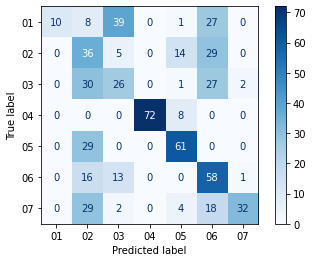

In [33]:
# 2.1
### Your code begins here ###
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
y_test = list(df_test_acc_pca_un['exercise_id'])
unique_labels = np.unique(y_test)

cm = confusion_matrix(y_test, y_pred)
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues')
### Your code ends here ###

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

In [34]:
y_pred = normalize_and_fuse(df_test_dc_pca_dis, df_test_dc_lda_dis)
y_pred = [df_train_dc_pca_un.iloc[i]['exercise_id'] for i in y_pred]


F1-score: 0.5485189300067064


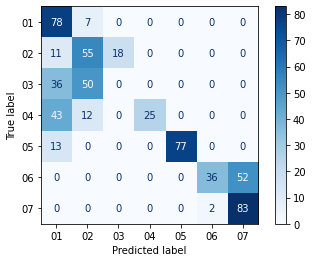

In [35]:
# 2.2

### Your code begins here ###
y_test = list(df_test_dc_pca_un['exercise_id'])
unique_labels = np.unique(y_test)

cm = confusion_matrix(y_test, y_pred)
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues')
### Your code ends here ###

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as 
<br>   

<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>

Document your work.
    
</div>

In [89]:
def cal_mean_std(df, data='acc'):
    df_ = df.copy()
    means = []
    stds = []
    if data == 'acc':
        reshape_values = (3, 10)
    elif data == 'dc':
        reshape_values = (5, 10)
    
    for _, row in df_.iterrows():
        numerical_values = np.asarray(row[2:].values, dtype=float)
        numerical_values = numerical_values.reshape(reshape_values)
        
        means.append(np.mean(numerical_values, axis=1))
        stds.append(np.std(numerical_values, axis=1))
    
    means = np.array(means)
    stds = np.array(stds)
    feat = np.concatenate((means, stds), axis=1)
    
    print(feat.shape)

    for i in range(feat.shape[1]):
        df_[f'new_feature{i+1}'] = feat[:, i]
    print(df_.shape)
    
    return df_

In [85]:
df_train_acc_pca_10, df_test_acc_pca_10 = pca_reduce_dim(df_train_acc_st, df_test_acc_st, 10)

In [86]:
df_train_acc_pca_10 = un_window(df_train_acc_pca_10)
df_test_acc_pca_10 = un_window(df_test_acc_pca_10)

In [87]:
df_train_acc_pca_10

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29
0,01,01,9.446390,-0.100161,1.337527,-0.427952,1.584236,-0.091523,-0.641931,0.006217,...,-4.428180,-10.071520,-1.544047,0.527774,-0.290541,-1.058776,-0.079726,-0.034836,0.199251,-0.363423
1,01,01,10.279451,0.350062,-0.832784,1.823521,-0.705574,-0.627988,0.253038,0.321098,...,-7.641348,4.657154,-5.537625,-0.473559,1.398964,-1.095631,-1.072875,-0.571307,0.162012,-0.230666
2,01,01,10.180005,-0.166872,-0.476363,-2.050209,-0.805986,0.034600,0.520434,-0.302299,...,-2.534229,5.275346,6.331572,0.829374,-1.140164,-1.934760,-0.947876,0.105064,-0.150000,-0.212149
3,01,01,9.748982,0.166028,1.216415,0.603697,1.552957,0.058885,-0.737332,-0.540066,...,-3.948800,-9.204254,0.716698,-0.019989,-1.487629,-2.037139,-0.427179,0.193513,0.170370,-0.124866
4,01,01,10.551685,-0.028662,-0.874917,1.393513,-1.164957,-0.512901,-0.148164,0.568184,...,-6.930082,3.168623,-6.074279,-0.522035,0.673620,-1.337181,-1.228069,-0.455657,0.473541,0.028764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,12.300086,-7.560771,0.035711,-0.519517,0.303762,1.624410,0.524352,-0.510092,...,-1.311852,-3.603153,-0.773634,0.232074,0.110516,0.502809,0.221739,-0.071872,-0.137625,0.214137
1482,07,07,6.128600,-1.305088,-2.443488,2.473615,2.126193,1.590983,-0.596044,0.394990,...,-4.342852,-0.292144,-0.673540,0.738306,0.836752,0.405726,-0.149606,0.112572,0.086340,0.219079
1483,07,07,5.948453,1.542386,-1.398224,-1.973479,1.447783,-1.096674,-0.847375,-0.751746,...,-4.682058,0.066080,0.010413,-0.018325,0.158330,-0.155979,0.030666,0.022355,0.071683,-0.099342
1484,07,07,12.358662,7.042130,-0.388923,0.351646,-0.355926,-1.498213,-0.545348,0.239019,...,-1.957782,3.005787,-1.393600,-0.586400,-0.549556,-0.120583,-0.182137,-0.433129,0.013288,0.014173


In [90]:
F_train_acc_pc = cal_mean_std(df_train_acc_pca_10, data='acc')
F_test_acc_pc = cal_mean_std(df_test_acc_pca_10, data='acc')

(1486, 6)
(1486, 38)
(598, 6)
(598, 38)


In [62]:
F_train_acc_pc

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_26,feature_27,feature_28,feature_29,new_feature1,new_feature2,new_feature3,new_feature4,new_feature5,new_feature6
0,01,01,9.446390,-0.100161,1.337527,-0.427952,1.584236,-0.091523,-0.641931,0.006217,...,-0.079726,-0.034836,0.199250,-0.363450,1.098344,0.882569,-1.714405,2.865600,4.150332,3.093539
1,01,01,10.279451,0.350062,-0.832784,1.823521,-0.705574,-0.627988,0.253038,0.321098,...,-1.072875,-0.571307,0.162011,-0.230678,1.047364,1.138712,-1.040489,3.161867,3.870897,3.238164
2,01,01,10.180005,-0.166872,-0.476363,-2.050209,-0.805986,0.034600,0.520434,-0.302299,...,-0.947876,0.105063,-0.150001,-0.212172,0.715931,1.586146,0.562215,3.225918,4.378307,2.790837
3,01,01,9.748982,0.166028,1.216415,0.603697,1.552957,0.058885,-0.737332,-0.540066,...,-0.427179,0.193513,0.170368,-0.124877,1.178408,1.031746,-1.616929,2.938014,4.273612,2.851461
4,01,01,10.551685,-0.028662,-0.874917,1.393513,-1.164957,-0.512901,-0.148164,0.568184,...,-1.228069,-0.455657,0.473540,0.028751,0.948265,0.955362,-1.220277,3.272075,4.088427,2.907361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,12.300086,-7.560771,0.035711,-0.519517,0.303762,1.624410,0.524352,-0.510092,...,0.221739,-0.071872,-0.137624,0.214141,0.712825,1.969168,-0.461686,4.554869,3.818311,1.166562
1482,07,07,6.128600,-1.305088,-2.443488,2.473615,2.126193,1.590983,-0.596044,0.394990,...,-0.149606,0.112572,0.086339,0.219062,0.833587,1.644033,-0.305938,2.279953,5.480024,1.412931
1483,07,07,5.948453,1.542386,-1.398224,-1.973479,1.447783,-1.096674,-0.847375,-0.751746,...,0.030666,0.022355,0.071683,-0.099338,0.288504,2.011987,-0.459617,2.183352,5.413486,1.409959
1484,07,07,12.358662,7.042130,-0.388923,0.351646,-0.355926,-1.498213,-0.545348,0.239019,...,-0.182137,-0.433130,0.013289,0.014157,1.640241,0.891269,-0.218995,4.227952,4.301572,1.233360


In [63]:
F_test_acc_pc

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_26,feature_27,feature_28,feature_29,new_feature1,new_feature2,new_feature3,new_feature4,new_feature5,new_feature6
0,08,01,12.492836,0.658924,-0.144612,-0.345418,-2.197639,-0.271130,-0.490879,-0.018332,...,0.351191,0.423714,0.268788,-0.496466,0.991866,-0.875919,1.152187,3.901283,3.795559,2.424608
1,08,01,13.014931,0.470656,0.751311,-0.811650,-1.198665,1.037506,-0.308273,0.524645,...,0.465925,-0.845674,-0.127912,-0.385252,1.430885,-1.459569,-0.515936,3.919062,3.356872,2.771283
2,08,01,13.186730,-0.190409,-0.828289,-1.316217,0.401873,1.382418,0.296772,0.238352,...,-0.504123,0.057119,-0.493211,0.161024,1.319219,-0.877549,1.497961,4.015678,3.693737,2.056444
3,08,01,13.551650,1.185973,0.069291,0.111171,1.588247,0.770995,0.044713,-0.195188,...,0.264386,0.277229,0.068385,-0.171050,1.702809,-1.390342,-0.489522,3.991622,3.444788,2.483356
4,08,01,13.527126,-1.143232,-0.324420,-0.588443,1.805149,-0.811585,0.389432,0.797254,...,0.152344,-0.658159,0.562526,-0.353760,1.338353,-0.940355,1.146068,4.148864,3.607414,2.177910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,10,07,17.441718,3.131559,2.540762,-2.446056,-0.596044,0.127477,-0.628363,0.363963,...,0.292712,-0.036707,0.187914,0.375367,1.991306,0.318579,0.263223,5.364016,2.663050,0.842204
594,10,07,20.256104,-0.023171,-0.147321,0.054601,-0.006177,0.057174,0.062227,0.072778,...,-0.239053,-0.453747,0.250558,-0.008931,2.041511,0.198754,0.186440,6.071923,0.491280,0.898969
595,10,07,17.115983,-3.634301,1.916429,0.884890,1.232560,-0.819145,-0.568229,0.026632,...,-0.806574,-0.081085,-0.054907,-0.053573,1.591902,-0.615735,-0.088672,5.365176,2.778342,0.961277
596,10,07,17.019756,1.226160,-3.800250,1.605262,-1.145822,-1.095760,-0.500570,0.028831,...,-0.322613,0.455273,0.220730,-0.293101,1.390372,-0.962252,0.160314,5.402221,2.757189,0.694686


<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>

Document your work.
    
</div>

In [64]:
df_train_dc_pca_10, df_test_dc_pca_10 = pca_reduce_dim(df_train_dc_st, df_test_dc_st, 10)
F_train_dc_pc = un_window(df_train_dc_pca_10)
F_test_dc_pc = un_window(df_test_dc_pca_10)

In [66]:
F_train_dc_pc

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,01,01,-2.048222,3.117207,-0.645285,-0.110631,1.582621,0.106205,-0.491078,-0.043455,...,-2.626550,0.598975,-2.965497,-2.281678,1.418664,0.317962,-1.715043,1.267232,0.681434,-1.749282
1,01,01,-3.212173,-1.231978,0.179486,1.350845,-2.537895,-0.999434,1.661578,-1.104569,...,-1.271315,0.394254,-2.169766,-2.514655,1.608785,0.543556,-0.862114,0.465581,0.068099,-1.152510
2,01,01,-2.626550,0.598975,-2.965497,-2.281678,1.418664,0.317962,-1.715043,1.267232,...,-2.587343,-0.962411,-0.303417,1.704458,-2.565177,-1.038176,1.719550,-1.892069,-1.199757,-1.077347
3,01,01,-1.271315,0.394254,-2.169766,-2.514655,1.608785,0.543556,-0.862114,0.465581,...,0.511378,3.602251,-3.168714,-1.159125,1.625982,-0.157461,-2.353880,0.228113,-0.428691,-0.376425
4,01,01,-2.587343,-0.962411,-0.303417,1.704458,-2.565177,-1.038176,1.719550,-1.892069,...,-0.741002,3.842546,-2.792846,-0.587653,1.290127,0.413275,-2.573609,0.791763,-0.994083,-0.011277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,8.887065,-1.878538,0.151937,-0.788782,-0.234798,-0.656061,3.519167,-3.949278,...,8.878798,0.138466,1.741467,3.768093,-0.802084,5.019144,-1.567894,1.312777,1.272039,-1.039453
1482,07,07,7.896121,-3.847549,-1.512540,-2.188034,-0.882725,0.558385,1.393896,-2.041583,...,10.433798,-1.016735,1.797721,3.142628,-1.553896,5.576171,-1.591556,0.962749,0.034037,-1.393652
1483,07,07,8.878798,0.138466,1.741467,3.768093,-0.802084,5.019144,-1.567894,1.312777,...,9.948332,-1.727281,2.172829,3.911490,-0.892142,4.996349,-0.772867,-0.354392,-1.591145,-1.056069
1484,07,07,10.433798,-1.016735,1.797721,3.142628,-1.553896,5.576171,-1.591556,0.962749,...,7.550559,-4.979392,1.769986,3.983141,-2.431782,1.492230,-0.434005,-0.208574,-1.730757,-0.250968


In [67]:
F_test_dc_pc

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,08,01,-3.234274,1.390312,0.350393,0.730432,1.077657,0.294046,1.045627,-1.851104,...,-3.669230,1.151927,-1.350203,-2.486411,0.931381,0.559571,-0.747369,0.341534,-0.267855,-1.473600
1,08,01,-3.357520,1.153509,0.831178,-0.570910,1.485708,-0.095518,0.172277,-0.125239,...,-3.591181,1.516439,0.199266,1.171382,0.793148,-0.228327,0.917154,-2.400516,-1.639792,-1.260267
2,08,01,-3.669230,1.151927,-1.350203,-2.486411,0.931381,0.559571,-0.747369,0.341534,...,-3.761063,2.584128,-3.613346,-1.887260,0.256666,0.326450,-1.367636,1.872117,-0.162546,-2.297859
3,08,01,-3.591181,1.516439,0.199266,1.171382,0.793148,-0.228327,0.917154,-2.400516,...,-2.946647,1.397978,1.355197,0.619456,1.177769,-0.873258,0.644156,-2.280761,-1.658091,-0.951784
4,08,01,-3.761063,2.584128,-3.613346,-1.887260,0.256666,0.326450,-1.367636,1.872117,...,-4.170074,1.234288,-2.058290,-1.854368,0.685393,0.149658,-0.687471,1.063489,0.153550,-1.881658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,10,07,17.150243,0.645615,-2.321620,-3.061004,5.555457,-1.677716,2.494948,1.702789,...,15.311315,3.772751,3.217293,6.267864,-1.121930,4.265812,-1.634963,0.488288,-1.869288,-2.003821
594,10,07,12.894966,2.182792,-3.896835,-4.455370,3.584340,-1.758819,-2.414824,1.008557,...,12.297607,2.016830,3.467040,4.345534,-2.810517,2.006886,-0.897610,-1.588404,-2.351021,-0.761511
595,10,07,15.311315,3.772751,3.217293,6.267864,-1.121930,4.265812,-1.634963,0.488288,...,17.979789,1.966771,-1.361567,-2.240353,4.153000,-2.169632,3.254127,-0.629358,0.902226,-2.086724
596,10,07,12.297607,2.016830,3.467040,4.345534,-2.810517,2.006886,-0.897610,-1.588404,...,16.078702,4.199341,-0.801177,-3.395380,2.389737,-2.440565,0.465915,1.052006,0.331674,-0.645888


<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>

Note: Normalize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes. (The expected F1 score for this task should generally fall within the range of 55 to 70)
    
</div>

In [68]:
final_feature_train = pd.concat([F_train_acc_pc, F_train_dc_pc.iloc[:,2:]], axis=1)
final_feature_test = pd.concat([F_test_acc_pc, F_test_dc_pc.iloc[:,2:]], axis=1)

In [69]:
final_feature_train

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,01,01,9.446390,-0.100161,1.337527,-0.427952,1.584236,-0.091523,-0.641931,0.006217,...,-2.626550,0.598975,-2.965497,-2.281678,1.418664,0.317962,-1.715043,1.267232,0.681434,-1.749282
1,01,01,10.279451,0.350062,-0.832784,1.823521,-0.705574,-0.627988,0.253038,0.321098,...,-1.271315,0.394254,-2.169766,-2.514655,1.608785,0.543556,-0.862114,0.465581,0.068099,-1.152510
2,01,01,10.180005,-0.166872,-0.476363,-2.050209,-0.805986,0.034600,0.520434,-0.302299,...,-2.587343,-0.962411,-0.303417,1.704458,-2.565177,-1.038176,1.719550,-1.892069,-1.199757,-1.077347
3,01,01,9.748982,0.166028,1.216415,0.603697,1.552957,0.058885,-0.737332,-0.540066,...,0.511378,3.602251,-3.168714,-1.159125,1.625982,-0.157461,-2.353880,0.228113,-0.428691,-0.376425
4,01,01,10.551685,-0.028662,-0.874917,1.393513,-1.164957,-0.512901,-0.148164,0.568184,...,-0.741002,3.842546,-2.792846,-0.587653,1.290127,0.413275,-2.573609,0.791763,-0.994083,-0.011277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,12.300086,-7.560771,0.035711,-0.519517,0.303762,1.624410,0.524352,-0.510092,...,8.878798,0.138466,1.741467,3.768093,-0.802084,5.019144,-1.567894,1.312777,1.272039,-1.039453
1482,07,07,6.128600,-1.305088,-2.443488,2.473615,2.126193,1.590983,-0.596044,0.394990,...,10.433798,-1.016735,1.797721,3.142628,-1.553896,5.576171,-1.591556,0.962749,0.034037,-1.393652
1483,07,07,5.948453,1.542386,-1.398224,-1.973479,1.447783,-1.096674,-0.847375,-0.751746,...,9.948332,-1.727281,2.172829,3.911490,-0.892142,4.996349,-0.772867,-0.354392,-1.591145,-1.056069
1484,07,07,12.358662,7.042130,-0.388923,0.351646,-0.355926,-1.498213,-0.545348,0.239019,...,7.550559,-4.979392,1.769986,3.983141,-2.431782,1.492230,-0.434005,-0.208574,-1.730757,-0.250968


In [70]:
final_feature_test

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,08,01,12.492836,0.658924,-0.144612,-0.345418,-2.197639,-0.271130,-0.490879,-0.018332,...,-3.669230,1.151927,-1.350203,-2.486411,0.931381,0.559571,-0.747369,0.341534,-0.267855,-1.473600
1,08,01,13.014931,0.470656,0.751311,-0.811650,-1.198665,1.037506,-0.308273,0.524645,...,-3.591181,1.516439,0.199266,1.171382,0.793148,-0.228327,0.917154,-2.400516,-1.639792,-1.260267
2,08,01,13.186730,-0.190409,-0.828289,-1.316217,0.401873,1.382418,0.296772,0.238352,...,-3.761063,2.584128,-3.613346,-1.887260,0.256666,0.326450,-1.367636,1.872117,-0.162546,-2.297859
3,08,01,13.551650,1.185973,0.069291,0.111171,1.588247,0.770995,0.044713,-0.195188,...,-2.946647,1.397978,1.355197,0.619456,1.177769,-0.873258,0.644156,-2.280761,-1.658091,-0.951784
4,08,01,13.527126,-1.143232,-0.324420,-0.588443,1.805149,-0.811585,0.389432,0.797254,...,-4.170074,1.234288,-2.058290,-1.854368,0.685393,0.149658,-0.687471,1.063489,0.153550,-1.881658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,10,07,17.441718,3.131559,2.540762,-2.446056,-0.596044,0.127477,-0.628363,0.363963,...,15.311315,3.772751,3.217293,6.267864,-1.121930,4.265812,-1.634963,0.488288,-1.869288,-2.003821
594,10,07,20.256104,-0.023171,-0.147321,0.054601,-0.006177,0.057174,0.062227,0.072778,...,12.297607,2.016830,3.467040,4.345534,-2.810517,2.006886,-0.897610,-1.588404,-2.351021,-0.761511
595,10,07,17.115983,-3.634301,1.916429,0.884890,1.232560,-0.819145,-0.568229,0.026632,...,17.979789,1.966771,-1.361567,-2.240353,4.153000,-2.169632,3.254127,-0.629358,0.902226,-2.086724
596,10,07,17.019756,1.226160,-3.800250,1.605262,-1.145822,-1.095760,-0.500570,0.028831,...,16.078702,4.199341,-0.801177,-3.395380,2.389737,-2.440565,0.465915,1.052006,0.331674,-0.645888


In [73]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(final_feature_train.iloc[:, 2:].values)
y_train = final_feature_train.iloc[:, 1].values

X_test = scaler.transform(final_feature_test.iloc[:, 2:].values)
y_test = final_feature_test.iloc[:, 1].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1486, 86)
(1486,)
(598, 86)
(598,)


F1-score: 0.7051951227495094


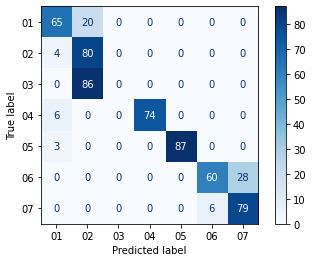

In [74]:
# 3.3

### Your code begins here ###
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues')
### Your code ends here ###

F1-score: 0.8322658942260687


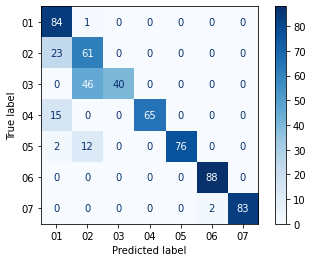

In [50]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(f"F1-score: {f1_score(y_test, y_pred, average='macro')}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap='Blues')

GaussianNB performed better than SVC with f1-score more than expected, I expected some bug or data leakage for GaussianNB but could not find any reason for this higher f1-score

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as 
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$.<br>
Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>

Note: Normalize the data along each axis.
<br>

Document your work, answer the given question, evaluate the results, and analyse the outcomes.
    
</div>

In [51]:
F_train_acc

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_26,feature_27,feature_28,feature_29,new_feature1,new_feature2,new_feature3,new_feature4,new_feature5,new_feature6
0,01,01,9.446390,-0.100161,1.337527,-0.427952,1.584236,-0.091523,-0.641931,0.006217,...,-0.079726,-0.034836,0.199250,-0.363450,1.098344,0.882569,-1.714405,2.865600,4.150332,3.093539
1,01,01,10.279451,0.350062,-0.832784,1.823521,-0.705574,-0.627988,0.253038,0.321098,...,-1.072875,-0.571307,0.162011,-0.230678,1.047364,1.138712,-1.040489,3.161867,3.870897,3.238164
2,01,01,10.180005,-0.166872,-0.476363,-2.050209,-0.805986,0.034600,0.520434,-0.302299,...,-0.947876,0.105063,-0.150001,-0.212172,0.715931,1.586146,0.562215,3.225918,4.378307,2.790837
3,01,01,9.748982,0.166028,1.216415,0.603697,1.552957,0.058885,-0.737332,-0.540066,...,-0.427179,0.193513,0.170368,-0.124877,1.178408,1.031746,-1.616929,2.938014,4.273612,2.851461
4,01,01,10.551685,-0.028662,-0.874917,1.393513,-1.164957,-0.512901,-0.148164,0.568184,...,-1.228069,-0.455657,0.473540,0.028751,0.948265,0.955362,-1.220277,3.272075,4.088427,2.907361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,12.300086,-7.560771,0.035711,-0.519517,0.303762,1.624410,0.524352,-0.510092,...,0.221739,-0.071872,-0.137624,0.214141,0.712825,1.969168,-0.461686,4.554869,3.818311,1.166562
1482,07,07,6.128600,-1.305088,-2.443488,2.473615,2.126193,1.590983,-0.596044,0.394990,...,-0.149606,0.112572,0.086339,0.219062,0.833587,1.644033,-0.305938,2.279953,5.480024,1.412931
1483,07,07,5.948453,1.542386,-1.398224,-1.973479,1.447783,-1.096674,-0.847375,-0.751746,...,0.030666,0.022355,0.071683,-0.099338,0.288504,2.011987,-0.459617,2.183352,5.413486,1.409959
1484,07,07,12.358662,7.042130,-0.388923,0.351646,-0.355926,-1.498213,-0.545348,0.239019,...,-0.182137,-0.433130,0.013289,0.014157,1.640241,0.891269,-0.218995,4.227952,4.301572,1.233360


In [52]:
F_train_dc

,subject_id,exercise_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,01,01,-2.048222,3.117206,-0.645284,-0.110604,1.582501,0.105558,-0.489462,-0.045567,...,-2.626550,0.598975,-2.965499,-2.281680,1.418589,0.317952,-1.714608,1.267696,0.679457,-1.738066
1,01,01,-3.212173,-1.231979,0.179495,1.350855,-2.537936,-0.999300,1.661671,-1.104748,...,-1.271315,0.394254,-2.169774,-2.514609,1.608677,0.543044,-0.860669,0.465214,0.062437,-1.138279
2,01,01,-2.626550,0.598975,-2.965499,-2.281680,1.418589,0.317952,-1.714608,1.267696,...,-2.587343,-0.962411,-0.303410,1.704493,-2.565199,-1.037884,1.719526,-1.892704,-1.201675,-1.066686
3,01,01,-1.271315,0.394254,-2.169774,-2.514609,1.608677,0.543044,-0.860669,0.465214,...,0.511378,3.602251,-3.168728,-1.159048,1.625847,-0.157723,-2.351785,0.228040,-0.434774,-0.365540
4,01,01,-2.587343,-0.962411,-0.303410,1.704493,-2.565199,-1.037884,1.719526,-1.892704,...,-0.741002,3.842546,-2.792856,-0.587597,1.289994,0.413705,-2.572186,0.792619,-0.997642,0.003163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,07,07,8.887065,-1.878537,0.151931,-0.788786,-0.234909,-0.655910,3.520437,-3.947592,...,8.878798,0.138466,1.741463,3.768069,-0.802103,5.019285,-1.567931,1.313472,1.274994,-1.043965
1482,07,07,7.896121,-3.847549,-1.512542,-2.188043,-0.882770,0.558533,1.393912,-2.039857,...,10.433798,-1.016735,1.797735,3.142582,-1.553897,5.575311,-1.591852,0.960330,0.030470,-1.397240
1483,07,07,8.878798,0.138466,1.741463,3.768069,-0.802103,5.019285,-1.567931,1.313472,...,9.948332,-1.727281,2.172838,3.911464,-0.892156,4.995920,-0.773009,-0.355531,-1.593051,-1.058494
1484,07,07,10.433798,-1.016735,1.797735,3.142582,-1.553897,5.575311,-1.591852,0.960330,...,7.550559,-4.979392,1.769982,3.983120,-2.431952,1.492956,-0.433031,-0.202313,-1.730081,-0.232098


In [53]:
scaler = MinMaxScaler()
X_train_Ac = scaler.fit_transform(F_train_acc.iloc[:, 2:].values)
y_train_Ac = F_train_acc.iloc[:, 1].values

X_test_Ac = scaler.transform(F_test_acc.iloc[:, 2:].values)
y_test_Ac = F_test_acc.iloc[:, 1].values

scaler2 = MinMaxScaler()
X_train_Dc = scaler2.fit_transform(F_train_dc.iloc[:, 2:].values)
y_train_Dc = F_train_dc.iloc[:, 1].values

X_test_Dc = scaler2.transform(F_test_dc.iloc[:, 2:].values)
y_test_Dc = F_test_dc.iloc[:,1].values

print(X_train_Ac.shape)
print(y_train_Ac.shape)

print(X_test_Ac.shape)
print(y_test_Ac.shape)

print(X_train_Dc.shape)
print(y_train_Dc.shape)

print(X_test_Dc.shape)
print(y_test_Dc.shape)

(1486, 36)
(1486,)
(598, 36)
(598,)
(1486, 50)
(1486,)
(598, 50)
(598,)


In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

def perform_grid_search(model, param_grid, X_train, y_train, cv=10):
    
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1_macro', refit=True)
    grid_search.fit(X_train, y_train)
    
    print(f"Best score = {grid_search.best_score_}, Best parameters: {grid_search.best_params_}")
    return grid_search

svc_param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0],
    'kernel': ['rbf']
}

adaboost_param_grid = {
    'n_estimators': [50, 100, 500, 1000],
    'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]
}

svc_grid_ac = perform_grid_search(SVC(probability=True), svc_param_grid, X_train_Ac, y_train_Ac)
svc_grid_dc = perform_grid_search(SVC(probability=True), svc_param_grid, X_train_Dc, y_train_Dc)

adaboost_grid_ac = perform_grid_search(AdaBoostClassifier(random_state=0), adaboost_param_grid, X_train_Ac, y_train_Ac)
adaboost_grid_dc = perform_grid_search(AdaBoostClassifier(random_state=0), adaboost_param_grid, X_train_Dc, y_train_Dc)

Best score = 0.9638706019775828, Best parameters: {'C': 100.0, 'gamma': 2.0, 'kernel': 'rbf'}
Best score = 0.964786371088372, Best parameters: {'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}
Best score = 0.778674795148063, Best parameters: {'learning_rate': 0.5, 'n_estimators': 1000}
Best score = 0.6296495104959023, Best parameters: {'learning_rate': 0.75, 'n_estimators': 1000}


In [55]:
svc_ac_best = SVC(probability=True, **svc_grid_ac.best_params_)
svc_dc_best = SVC(probability=True, **svc_grid_dc.best_params_)

adaboost_ac_best = AdaBoostClassifier(random_state=0, **adaboost_grid_ac.best_params_)
adaboost_dc_best = AdaBoostClassifier(random_state=0, **adaboost_grid_dc.best_params_)

In [56]:
svc_ac_best.fit(X_train_Ac, y_train_Ac)
svc_dc_best.fit(X_train_Dc, y_train_Dc)

adaboost_ac_best.fit(X_train_Ac, y_train_Ac)
adaboost_dc_best.fit(X_train_Dc, y_train_Dc)

svc_ac_ypred = svc_ac_best.predict(X_test_Ac)
svc_dc_ypred = svc_dc_best.predict(X_test_Dc)

adaboost_ac_ypred = adaboost_ac_best.predict(X_test_Ac)
adaboost_dc_ypred = adaboost_dc_best.predict(X_test_Dc)

In [57]:
print("####### results of testing data ###########")
print(f"F1-score for accelerometer data with svc: {f1_score(y_test_Ac, svc_ac_ypred, average='macro')}")
print(f"F1-score for dc data with svc: {f1_score(y_test_Ac, svc_dc_ypred, average='macro')}")

print(f"F1-score for accelerometer data with adaboost: {f1_score(y_test_Ac, adaboost_ac_ypred, average='macro')}")
print(f"F1-score for dc data with adaboost: {f1_score(y_test_Ac, adaboost_dc_ypred, average='macro')}")

####### results of testing data ###########
F1-score for accelerometer data with svc: 0.5356069866806104
F1-score for dc data with svc: 0.5214389112554769
F1-score for accelerometer data with adaboost: 0.568026384213811
F1-score for dc data with adaboost: 0.42759385066035704


Since training F1-score is high there is considerable overfitting (more in case of svc than adaboost)

<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

In [58]:
# 4.2

### Your code begins here ###

SVC_Ac_prob = svc_ac_best.predict_proba(X_test_Ac)
SVC_Dc_prob = svc_dc_best.predict_proba(X_test_Dc)

Ada_Ac_prob = adaboost_ac_best.predict_proba(X_test_Ac)
Ada_Dc_prob = adaboost_dc_best.predict_proba(X_test_Dc)
### Your code ends here ###

<a id='task4'></a>
<div class=" alert alert-warning">
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>


 SVM_acc + 𝑆𝑉𝑀_depth 

F1 Min: 0.6823
F1 Max: 0.6823
F1 Prod: 0.689
F1 Sum: 0.6572


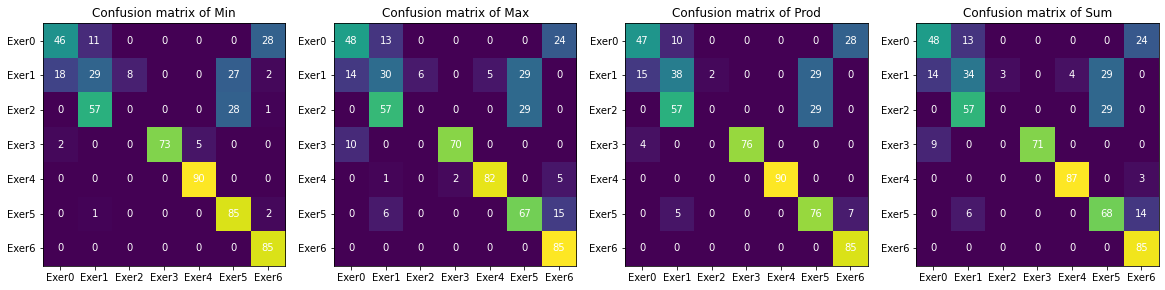


 Ada_Boost_acc + Ada_Boost_dc 

F1 Min: 0.7207
F1 Max: 0.7207
F1 Prod: 0.7676
F1 Sum: 0.7659


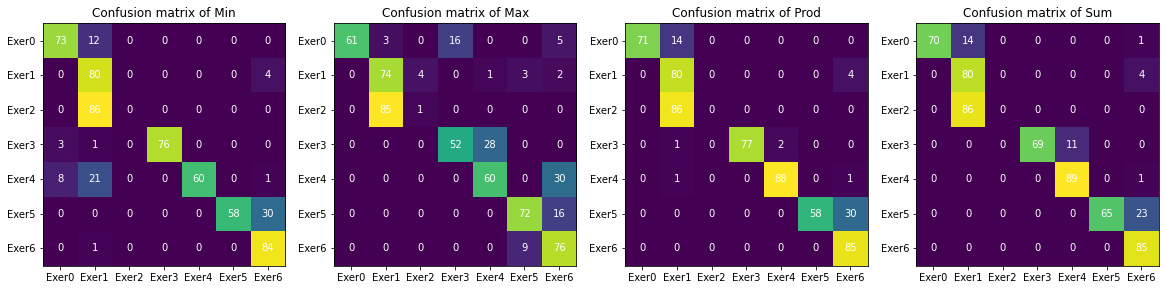


 SVM_acc + Ada_Boost_depth 

F1 Min: 0.7876
F1 Max: 0.7876
F1 Prod: 0.7742
F1 Sum: 0.6639


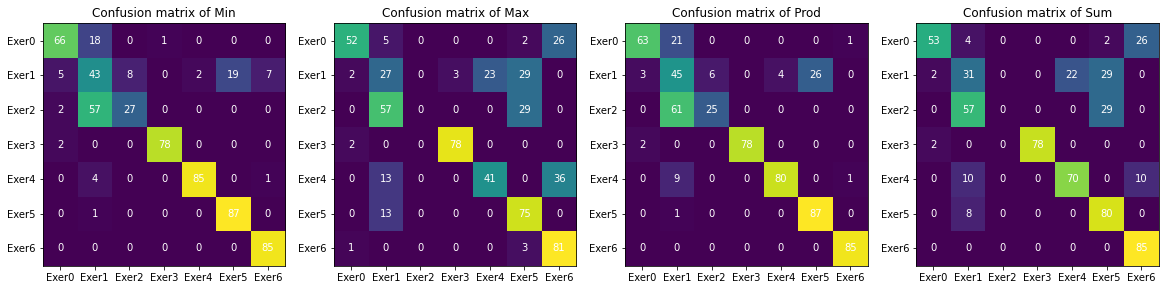


 Ada_Boost_acc + 𝑆𝑉𝑀_depth  

F1 Min: 0.6187
F1 Max: 0.6187
F1 Prod: 0.6037
F1 Sum: 0.5903


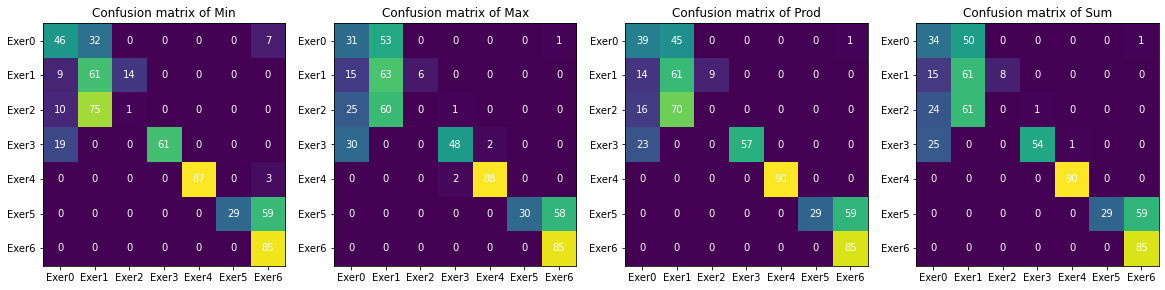

In [59]:
# 4.3

### Your code begins here ###
from sklearn.metrics import confusion_matrix, f1_score

def Confusion_Matrix_Graph(actuals, predictions, annotations,ax, rule):
    cm = confusion_matrix(actuals, predictions)
    ax.imshow(cm)
    for i in range(7):
        for j in range(7):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")
    
    ax.set_xticks(np.arange(len(annotations)))
    ax.set_yticks(np.arange(len(annotations)))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(annotations)
    ax.set_yticklabels(annotations)

    ax.set_title("Confusion matrix of "+rule)
    
                
def Combination(ypred1, ypred2, prob1, prob2, y_test):
    
    y_test = np.array([int(i) -1 for i in y_test])
    posterior_scores = np.array((prob1, prob2))
    
    Min = np.argmax(np.min(posterior_scores, axis=0),axis=1)
    Max = np.argmax(np.max(posterior_scores, axis=0),axis=1)
    Prod = np.argmax(np.prod(posterior_scores,axis=0),axis=1)
    Sum = np.argmax(np.sum(posterior_scores, axis=0), axis=1)
    
    test_F1 = round(f1_score(y_test, Min, average='micro'), 4)
    print('F1 Min:', test_F1)

    test_acc = round(f1_score(y_test, Max, average='micro'), 4)
    print('F1 Max:', test_F1)

    test_F1 = round(f1_score(y_test, Prod, average='micro'), 4)
    print('F1 Prod:', test_F1)
    
    test_F1 = round(f1_score(y_test, Sum, average='micro'), 4)
    print('F1 Sum:',test_F1)
    
    annotations = ['Exer'+str(i) for i in range(7)]
    
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(1,4,1)
    Confusion_Matrix_Graph(y_test, Min, annotations, ax1, 'Min')

    ax2 = fig.add_subplot(1,4,2)
    Confusion_Matrix_Graph(y_test, Max, annotations, ax2, 'Max')

    ax3 = fig.add_subplot(1,4,3)
    Confusion_Matrix_Graph(y_test, Prod, annotations, ax3, 'Prod')

    ax4 = fig.add_subplot(1,4,4)
    Confusion_Matrix_Graph(y_test, Sum, annotations, ax4, 'Sum')
    
    plt.show()

print('\n SVM_acc + 𝑆𝑉𝑀_depth \n')
Combination(svc_ac_ypred, svc_dc_ypred, SVC_Ac_prob, SVC_Dc_prob, y_test_Ac)

print('\n Ada_Boost_acc + Ada_Boost_dc \n')
Combination(adaboost_ac_ypred, adaboost_dc_ypred, Ada_Ac_prob, Ada_Dc_prob, y_test_Ac)

print('\n SVM_acc + Ada_Boost_depth \n')
Combination(svc_ac_ypred, adaboost_dc_ypred, SVC_Ac_prob, Ada_Dc_prob, y_test_Ac)

print('\n Ada_Boost_acc + 𝑆𝑉𝑀_depth  \n')
Combination(adaboost_ac_ypred, svc_ac_ypred, Ada_Ac_prob, SVC_Dc_prob, y_test_Ac)
### Your code ends here ###

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [60]:
# 5.1

### Your code begins here ###
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn.fit(F_Train_Ac.iloc[:, 2:].values, F_Train_Ac.iloc[:, 0].values)

ConfusionMatrixDisplay.from_estimator(
    knn,
    F_Test_Ac.iloc[:, 2:].values,
    F_Test_Ac.iloc[:, 0].values
)
y_pred = knn.predict(F_Test_Ac.iloc[:, 2:].values)
print('F1 Score =', f1_score(F_Test_Ac.iloc[:, 1].values, y_pred, average='macro'))

### Your code ends here ###

NameError: name 'F_Train_Ac' is not defined

<a id='task5'></a>
<div class=" alert alert-warning">

<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.2

### Your code begins here ###
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(F_Train_Ac.iloc[:, 2:].values, F_Train_Ac.iloc[:, 0].values)

ConfusionMatrixDisplay.from_estimator(
    gnb,
    F_Test_Ac.iloc[:, 2:].values,
    F_Test_Ac.iloc[:, 0].values
)
y_pred = gnb.predict(F_Test_Ac.iloc[:, 2:].values)
print('F1 Score =', f1_score(F_Test_Ac.iloc[:, 1].values, y_pred, average='macro'))
### Your code ends here ###